In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
import sys
sys.executable

'/Users/josh/opt/anaconda3/bin/python'

In [3]:
import sys
import os
import copy
import pathlib
import time
import gc

from tqdm import tqdm, trange
# from tqdm import trange

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

import torch
import torchvision
import torchvision.transforms as transforms

# import cuml

# for creating validation set
import sklearn
from sklearn.model_selection import train_test_split

%matplotlib inline
%matplotlib inline
# %matplotlib inline
# %matplotlib qt

/Users/josh/opt/anaconda3/lib/python3.8/site-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [4]:
# base_dir = '/n/data1/hms/neurobio/sabatini/josh'


In [7]:
import sys

base_dir = '/Users/josh/Documents'
sys.path.append(f'{base_dir}/github_repos')
data_folder = f'../../data/final'
simclr_model_folder = f'../../models/simclr-models'
model_performance_folder = f'../../reports/model-performance'
# sys.path.append(f'/media/rich/Home_Linux_partition/github_repos')
# dir_folders = r'/media/rich/bigSSD/for_Josh/GCAMP_ROI_Classifier_data/label_data'
# dir_folders = r'/users/Josh/Documents/Harvard/label_data'

%load_ext autoreload
%autoreload 2
from basic_neural_processing_modules import torch_helpers, math_functions, classification, h5_handling, plotting_helpers, indexing, misc, decomposition

# Must "pip install -e . in root project directory for this to work"
from GCaMP_ROI_classifier import util, dataset, models, training, augmentation

## Import unlabeled training data

In [8]:
# data_unlabeled = h5_handling.simple_load(path=r'/media/rich/bigSSD/for_Josh/GCAMP_ROI_Classifier_data/masks_20211202_balanced.h5')
data_unlabeled = h5_handling.simple_load(path=f'{data_folder}/masks_20211202_balanced.h5')

masks_cat_raw = torch.as_tensor(np.concatenate((data_unlabeled['SYTmasks'], data_unlabeled['NPmasks'], data_unlabeled['RHmasks']), axis=0), dtype=torch.float32, device='cpu')

In [9]:
# data_labeled = h5_handling.simple_load(path=r'/media/rich/bigSSD/for_Josh/GCAMP_ROI_Classifier_data/masks_20211202_unbalanced.h5')

data_labeled = h5_handling.simple_load(path=f'{data_folder}/masks_20211202_unbalanced.h5')

masks_SYT = data_labeled['SYTmasks']
labels_SYT = classification.squeeze_integers(data_labeled['SYTlabels'])

nan_lst = np.concatenate(np.where(np.isnan(masks_SYT).sum(axis=-1).sum(axis=-1)))
non_nan = [_ for _ in range(masks_SYT.shape[0]) if _ not in nan_lst]
labels_SYT = labels_SYT[non_nan]
masks_SYT = masks_SYT[non_nan]

X_labeled_train_SYT, X_labeled_val_SYT, y_labeled_train_SYT, y_labeled_val_SYT = train_test_split(masks_SYT, labels_SYT, test_size = 0.2)

toss any NaNs

In [10]:
print(f'Number of masks: {masks_cat_raw.shape}')

ROIs_without_NaNs = torch.where(~torch.any(torch.any(torch.isnan(masks_cat_raw), dim=1), dim=1))[0]
masks_cat = masks_cat_raw[ROIs_without_NaNs]

print(f'Number of masks: {masks_cat.shape}')

Number of masks: torch.Size([711808, 36, 36])
Number of masks: torch.Size([711807, 36, 36])


## Import labeled training data

concatenated images shape: (9715, 32, 32)


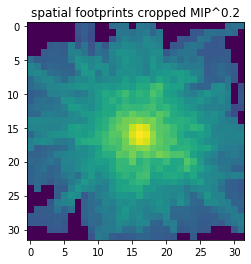

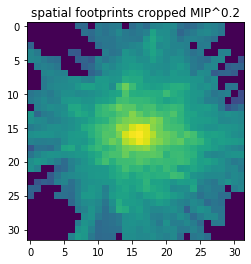

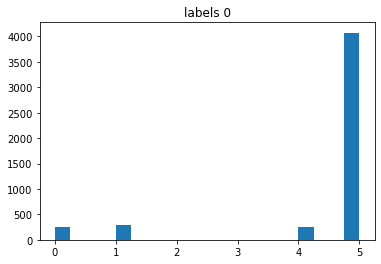

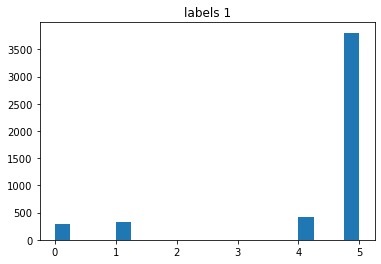

In [11]:
folders = [r'mouse 6_28 _ day 20200903/',
             r'mouse6_28 _ day20200815/']
fileNames_statFiles = [r'stat.npy']*len(folders)
paths_statFiles = [pathlib.Path(data_folder) / folders[ii] / fileNames_statFiles[ii] for ii in range(len(folders))]

sf_all = util.import_multiple_stat_files(   paths_statFiles=paths_statFiles,
                                            fileNames_statFiles=fileNames_statFiles,
                                            out_height_width=[32,32],
                                            max_footprint_width=241,
                                            plot_pref=True)
images_labeled_raw = np.concatenate(sf_all, axis=0)
images_labeled_raw = (images_labeled_raw / np.max(images_labeled_raw, axis=(1,2), keepdims=True)) * 1
print(f'concatenated images shape: {images_labeled_raw.shape}')

fileNames_labelFiles = ['labels_posthoc_filledIn_allCells.npy',
             'labels_posthoc_all.npy']
paths_labelFiles = [pathlib.Path(data_folder) / folders[ii] / fileNames_labelFiles[ii] for ii in range(len(folders))]

labels_all = util.import_multiple_label_files(paths_labelFiles=paths_labelFiles,
                                       plot_pref=True)
labels_raw = np.concatenate(labels_all)

assert np.alltrue([sf_all[ii].shape[0] == labels_all[ii].shape[0] for ii in range(len(sf_all))]) , 'num images in stat files does not correspond to num labels'

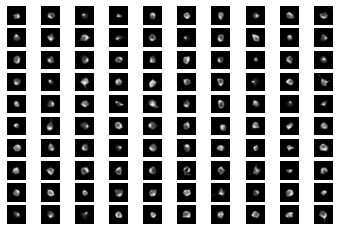

In [12]:
%matplotlib inline

plotting_helpers.plot_image_grid(images=images_labeled_raw,
                                labels=None,
                                grid_shape=(10,10), cmap=plt.get_cmap('gray'));

In [13]:
labels = classification.squeeze_integers(labels_raw)
images_labeled = images_labeled_raw[labels != 2]
labels = labels[labels != 2]
labels = classification.squeeze_integers(labels)

## Balance classes of inputs

In [14]:
duplicates = 1
balanced = True

images_dup = np.tile(images_labeled , (duplicates , 1 , 1))
labels_dup = np.tile(labels , (duplicates))

print(images_dup.shape)
print(labels_dup.shape)

if balanced:
    numToGetTo = np.sum(labels_dup==0)
    print(numToGetTo)
    for ii in np.array([1,2,3]):
  #     idxToDelete = np.cumsum(labels_dup==ii) <= (np.sum(labels_dup==ii) - numToGetTo)
        if ii==3:
            numToGetTo = np.sum(labels_dup==0)/1
        else:
            numToGetTo = np.sum(labels_dup==0)

        idxToDelete = (np.cumsum(labels_dup==ii) * (labels_dup==ii)) > numToGetTo
        images_dup = images_dup[idxToDelete==0,:,:]
        labels_dup = labels_dup[idxToDelete==0]





print(images_dup.shape)
print(labels_dup.shape)

numToGetTo = np.sum(labels_dup==0)
print(numToGetTo)

print(np.sum(labels_dup==0))
print(np.sum(labels_dup==1))
print(np.sum(labels_dup==4))
print(np.sum(labels_dup==5))
print(images_dup.shape)
print(labels_dup.shape)

(9714, 32, 32)
(9714,)
532
(2128, 32, 32)
(2128,)
532
532
532
0
0
(2128, 32, 32)
(2128,)


In [15]:
# create validation set

###### REMOVE WITH ENOUGH RAM
images = images_dup
labels = labels_dup

# X_labeled_train, X_labeled_val, y_labeled_train, y_labeled_val = train_test_split(images_dup, labels_dup, test_size = 0.3)
X_labeled_train, X_labeled_val, y_labeled_train, y_labeled_val = train_test_split(images_dup, labels_dup, test_size = 0.2)
# X_train, y_train = X_labeled_train, y_labeled_train

# X_labeled_val, X_test, y_labeled_val, y_test = train_test_split(X_labeled_val, y_labeled_val, test_size = 0.5)
X_val, X_test, y_val, y_test = train_test_split(X_labeled_val, y_labeled_val, test_size = 0.5)

(X_labeled_train.shape, y_labeled_train.shape), (X_labeled_val.shape, y_labeled_val.shape)

(((1702, 32, 32), (1702,)), ((426, 32, 32), (426,)))

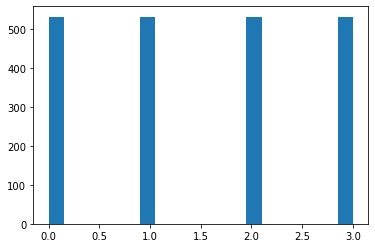

In [16]:
plt.figure()
plt.hist(labels_dup, 20);

In [17]:
images.shape

(2128, 32, 32)

# Train

In [18]:
DEVICE = torch_helpers.set_device(use_GPU=True)
# DEVICE = torch_helpers.set_device(use_GPU=False)

no GPU available. Using CPU.


### Define New model = model + pre-head + latent layer OR classification layer

In [19]:
class ModelTackOn(torch.nn.Module):
    def __init__(self, base_model, un_modified_model, pre_head_fc_sizes=[100], post_head_fc_sizes=[100], classifier_fc_sizes=None):
            super(ModelTackOn, self).__init__()
            self.base_model = base_model
            final_base_layer = list(un_modified_model.children())[-1]
            # final_base_layer = list(list(model.children())[-1].children())[-1]
            # print(final_base_layer)

            self.pre_head_fc_lst = []
            self.post_head_fc_lst = []
            self.classifier_fc_lst = []

            self.init_prehead(final_base_layer, pre_head_fc_sizes)
            self.init_posthead(pre_head_fc_sizes[-1], post_head_fc_sizes)
            if classifier_fc_sizes is not None:
                self.init_classifier(pre_head_fc_sizes[-1], classifier_fc_sizes)
    
    def init_prehead(self, prv_layer, pre_head_fc_sizes):
        for i, pre_head_fc in enumerate(pre_head_fc_sizes):
            if i == 0:
                in_features = prv_layer.in_features if hasattr(prv_layer,'in_features') else 1280
            else:
                in_features = pre_head_fc_sizes[i - 1]
            fc_layer = torch.nn.Linear(in_features=in_features, out_features=pre_head_fc)
            self.add_module(f'PreHead_{i}', fc_layer)
            self.pre_head_fc_lst.append(fc_layer)

#             if i < len(pre_head_fc_sizes) - 1:
            non_linearity = torch.nn.ReLU()
            self.add_module(f'PreHead_{i}_NonLinearity', non_linearity)
            self.pre_head_fc_lst.append(non_linearity)

    def init_posthead(self, prv_size, post_head_fc_sizes):
        for i, post_head_fc in enumerate(post_head_fc_sizes):
            if i == 0:
                in_features = prv_size
            else:
                in_features = post_head_fc_sizes[i - 1]
            fc_layer = torch.nn.Linear(in_features=in_features, out_features=post_head_fc)
            self.add_module(f'PostHead_{i}', fc_layer)
            self.post_head_fc_lst.append(fc_layer)

            if i < len(post_head_fc_sizes) - 1:
                non_linearity = torch.nn.ReLU()
                self.add_module(f'PostHead_{i}_NonLinearity', non_linearity)
                self.pre_head_fc_lst.append(non_linearity)
    
    def init_classifier(self, prv_size, classifier_fc_sizes):
            for i, classifier_fc in enumerate(classifier_fc_sizes):
                if i == 0:
                    in_features = prv_size
                else:
                    in_features = classifier_fc_sizes[i - 1]
            fc_layer = torch.nn.Linear(in_features=in_features, out_features=classifier_fc)
            self.add_module(f'Classifier_{i}', fc_layer)
            self.classifier_fc_lst.append(fc_layer)

    def reinit_classifier(self):
        for i_layer, layer in enumerate(self.classifier_fc_lst):
            layer.reset_parameters()
    
#     def forward(self, X):
#         interim = self.base_model(X)
#         interim = self.get_head(interim)
#         interim = self.get_latent(interim)
#         return interim

    def forward_classifier(self, X):
        interim = self.base_model(X)
        interim = self.get_head(interim)
        interim = self.classify(interim)
        return interim

    def forward_latent(self, X):
        interim = self.base_model(X)
        interim = self.get_head(interim)
        interim = self.get_latent(interim)
        return interim


    def get_head(self, base_out):
        # print('base_out', base_out.shape)
        head = base_out
        for pre_head_layer in self.pre_head_fc_lst:
          # print('pre_head_layer', pre_head_layer.in_features)
          head = pre_head_layer(head)
          # print('head', head.shape)
        return head

    def get_latent(self, head):
        latent = head
        for post_head_layer in self.post_head_fc_lst:
            latent = post_head_layer(latent)
        return latent

    def classify(self, head):
        logit = head
        for classifier_layer in self.classifier_fc_lst:
            logit = classifier_layer(logit)
        return logit

    def set_pre_head_grad(self, requires_grad=True):
        for layer in self.pre_head_fc_lst:
            for param in layer.parameters():
                param.requires_grad = requires_grad
                
    def set_post_head_grad(self, requires_grad=True):
        for layer in self.post_head_fc_lst:
            for param in layer.parameters():
                param.requires_grad = requires_grad

    def set_classifier_grad(self, requires_grad=True):
        for layer in self.classifier_fc_lst:
            for param in layer.parameters():
                param.requires_grad = requires_grad

    def prep_contrast(self):
        self.set_pre_head_grad(requires_grad=True)
        self.set_post_head_grad(requires_grad=True)
        self.set_classifier_grad(requires_grad=False)

    def prep_classifier(self):
        self.set_pre_head_grad(requires_grad=False)
        self.set_post_head_grad(requires_grad=False)
        self.set_classifier_grad(requires_grad=True)


In [20]:
# import torchvision.models

# # base_model = torchvision.models.resnet101(pretrained=True)
# base_model = torchvision.models.resnet18(pretrained=True)

# for param in base_model.parameters():
#     param.requires_grad = False

# retrain = list(base_model.children())[-1:]
# for layer in retrain:
#     params = layer.parameters()
#     for param in params:
#         param.requires_grad = True

In [21]:
import torchvision.models

# base_model_frozen = torchvision.models.resnet101(pretrained=True)
# base_model_frozen = torchvision.models.resnet18(pretrained=True)
# base_model_frozen = torchvision.models.wide_resnet50_2(pretrained=True)
# base_model_frozen = torchvision.models.resnet50(pretrained=True)

# base_model_frozen = torchvision.models.efficientnet_b0(pretrained=True)
base_model_frozen = torchvision.models.resnet18(pretrained=True)


for param in base_model_frozen.parameters():
    param.requires_grad = False

start with a pretrained resnet model, and chop off the final layer. This will be used as the base on which we add the pre-head layers (for expressivity), latent layers (for simCLR), or classification layers (for post-hoc logistic regression)

In [22]:
model_chopped = torch.nn.Sequential(*(list(base_model_frozen.children())[:-1] + [torch.nn.Flatten()]))

### Make combined model
'model' has two forward methods. One for generating latents (for simCLR) and one for classifying labels

In [23]:
model = ModelTackOn(model_chopped, base_model_frozen, pre_head_fc_sizes=[1024, 512], post_head_fc_sizes=[64], classifier_fc_sizes=[len(np.unique(y_labeled_train))])
# model = ModelTackOn(model_chopped.to(DEVICE), base_model_frozen, pre_head_fc_sizes=[len(np.unique(y_train))], post_head_fc_sizes=[])
# model = ModelTackOn(model_chopped.to(DEVICE), base_model_frozen, pre_head_fc_sizes=[len(np.unique(y_train))], post_head_fc_sizes=[])

# model = torch.nn.Sequential([model_chopped.to(DEVICE), torch.nn.Linear], pre_head_fc_sizes=[len(np.unique(y_train))], post_head_fc_sizes=[])


# model = ModelTackOn(base_model_frozen, pre_head_fc_sizes=[len(np.unique(y_train))], post_head_fc_sizes=[])
# model = ModelTackOn(base_model, pre_head_fc_sizes=[len(np.unique(y_train))], post_head_fc_sizes=[])
model.train();

In [24]:
base_model_frozen

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [25]:
# unfreeze particular blocks in ResNet model

# #efficient net 
# for name, param in list(model.named_parameters()):
#     print(name)
#     print(name)
#     if name[:10] == 'base_model':
#         if int(name[13]) < 7:
#             param.requires_grad = False
#         elif int(name[13]) >= 7:
#             param.requires_grad = True

# for name, param in list(model.named_parameters()):
#     if param.requires_grad:
#         print(name)


#ResNet18
for name, param in list(model.named_parameters()):
    if name[:10] == 'base_model':
        if int(name[11]) < 7:
            param.requires_grad = False
        elif int(name[11]) >= 7:
            param.requires_grad = True

for name, param in list(model.named_parameters()):
    if param.requires_grad:
        print(name)

base_model.7.0.conv1.weight
base_model.7.0.bn1.weight
base_model.7.0.bn1.bias
base_model.7.0.conv2.weight
base_model.7.0.bn2.weight
base_model.7.0.bn2.bias
base_model.7.0.downsample.0.weight
base_model.7.0.downsample.1.weight
base_model.7.0.downsample.1.bias
base_model.7.1.conv1.weight
base_model.7.1.bn1.weight
base_model.7.1.bn1.bias
base_model.7.1.conv2.weight
base_model.7.1.bn2.weight
base_model.7.1.bn2.bias
PreHead_0.weight
PreHead_0.bias
PreHead_1.weight
PreHead_1.bias
PostHead_0.weight
PostHead_0.bias
Classifier_0.weight
Classifier_0.bias


## Define augmentation pipeline

In [26]:
# import torchvision.transforms    

# transforms = torch.nn.Sequential(
#     torchvision.transforms.RandomHorizontalFlip(p=0.5),
        
#     torchvision.transforms.RandomAffine(
#                                         degrees=(-180,180),
#                                         translate=(0.15, 0.15), #0, .3, .45 (DEFAULT)
#                                         scale=(0.6, 1.2), # no scale (1,1), (0.4, 1.5)
#                                         shear=(-15, 15, -15, 15),
#                                         interpolation=torchvision.transforms.InterpolationMode.BILINEAR, 
#                                         fill=0, 
#                                         fillcolor=None, 
#                                         resample=None),
#     augmentation.AddPoissonNoise(   #scaler_bounds=(10**(4.5), 10**(6.)),
#                                     scaler_bounds=(10**(4), 10**(6)),
#                                     prob=1,
#                                     base=1000,
#                                     scaling='log'),
#     augmentation.AddGaussianNoise(  mean=0, 
#                                     std=0.00015,
#                                     prob=1),
    
#     augmentation.ScaleDynamicRange(scaler_bounds=(0,1)), # just clamping, both this and clamping = normalizing (DEFAULT)
#     # torchvision.transforms.Resize(size=(224,224), 
#     #                               interpolation=torchvision.transforms.InterpolationMode.BILINEAR), # To do or not to do (DEFAULT)
    
#     augmentation.TileChannels(dim=0, n_channels=3),
# )

import torchvision.transforms    

transforms = torch.nn.Sequential(
    # torchvision.transforms.RandomHorizontalFlip(p=0.5),    
    augmentation.ScaleDynamicRange(scaler_bounds=(0,1)), # just clamping, both this and clamping = normalizing (DEFAULT)
    augmentation.WarpPoints(r=[0, 1],
                            cx=[-0.5, 0.5],
                            cy=[-0.5, 0.5], 
                            dx=[-0.3, 0.0], 
                            dy=[-0.3, 0.0], 
                            n_warps=5,
                            prob=1.0,
                            img_size_in=[36, 36],
                            img_size_out=[224, 224]),

    
    augmentation.TileChannels(dim=0, n_channels=3),
#     torchvision.transforms.Resize(size=(224,224), 
#                                   interpolation=torchvision.transforms.InterpolationMode.BILINEAR), # To do or not to do (DEFAULT)
    
)
    

scripted_transforms = torch.jit.script(transforms)

Warp Initialization took: 0.0016109943389892578 s


/Users/josh/opt/anaconda3/lib/python3.8/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /Users/distiller/project/pytorch/aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [27]:
dataset_train = dataset.dataset_simCLR(
                                    torch.as_tensor(masks_cat, device='cpu', dtype=torch.float32), 
                                    torch.as_tensor(torch.zeros(masks_cat.shape[0]), device='cpu', dtype=torch.float32),

                                    n_transforms=2,
                                    class_weights=np.array([1]),
                                    # class_weights=np.array([1]*4)[np.random.randint(0,4, X_train.shape[0])],
                                    transform=scripted_transforms,
                                    # DEVICE='cpu',
                                    DEVICE='cpu',
                                    dtype_X=torch.float32,
                                    dtype_y=torch.int64,
                                    
                                    temp_uncertainty=16
                                    )
dataloader_train = torch.utils.data.DataLoader( dataset_train,
#                                                 batch_size=int(pct_batch_size*X_train.shape[0]),
                                                batch_size=800,
                                                # shuffle=True,
                                                shuffle=True,
                                                drop_last=True,
                                                pin_memory=True,
                                                num_workers=16,
                                                persistent_workers=True,
                                                # prefetch_factor=0
                                                )

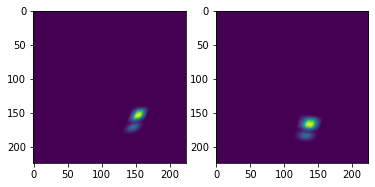

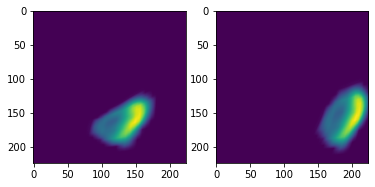

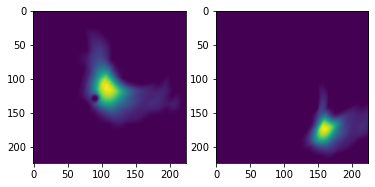

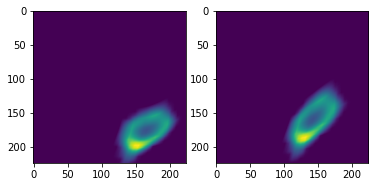

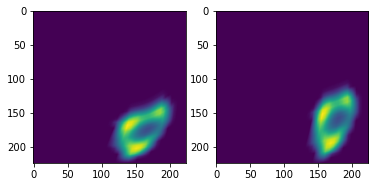

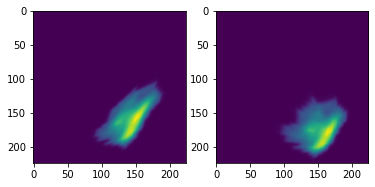

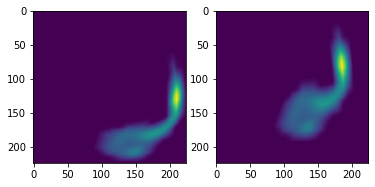

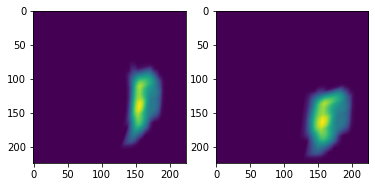

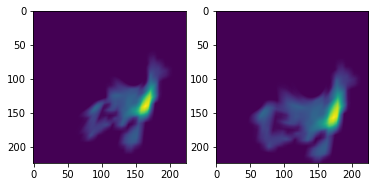

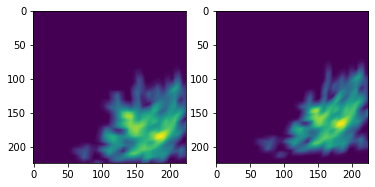

In [28]:
idx_rand = np.random.randint(0,masks_cat.shape[0], 10)
for ii in idx_rand:
    fig, axs = plt.subplots(1,2)
    # print(dataset_train[ii][0][0][0].shape)
    axs[0].imshow(dataset_train[ii][0][0][0])
    axs[1].imshow(dataset_train[ii][0][1][0])

In [29]:
# torch_helpers.delete_all_cuda_tensors(globals())

import gc

torch.cuda.empty_cache()
gc.collect()
torch.cuda.empty_cache()
gc.collect()
torch.cuda.empty_cache()
gc.collect()
torch.cuda.empty_cache()
gc.collect()

0

## Training

In [30]:
model.to(DEVICE)
model.prep_contrast()

In [31]:
from torch.nn import CrossEntropyLoss
from torch.optim import Adam

import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


# model = models.LeNet1(dropout_prob=0.3, momentum_val=0, n_output_features=64)


criterion = [CrossEntropyLoss()]
# criterion = CrossEntropyLoss(reduction='none')

# optimizer = Adam(model.parameters(), lr=1e-2, weight_decay=0.0)
# optimizer = Adam(model.parameters(), lr=2e-2)
optimizer = Adam(model.parameters(), lr=10**(-3.5))
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer,
                                                   gamma=1-0.0000,
#                                                    gamma=1,
                                                  )

criterion = [_.to(DEVICE) for _ in criterion]
losses_train, losses_val, val_accs, acc = [], [np.nan], [], []

In [32]:
def get_ds_dl(data, transforms, expand_dim=False):
    setup_ds = dataset.dataset_simCLR(
                                    torch.as_tensor(data, device='cpu', dtype=torch.float32), 
                                    torch.as_tensor(torch.zeros(data.shape[0]), device='cpu', dtype=torch.float32),


                                    n_transforms=1,
                                    transform=transforms,
                                    class_weights=np.array([1]),
                                    DEVICE='cpu',
                                    dtype_X=torch.float32,
                                    dtype_y=torch.int64,

                                    temp_uncertainty=16,
                                    expand_dim=expand_dim
                                    )
    setup_dl = torch.utils.data.DataLoader( setup_ds,
                                            batch_size=1024,
                                            shuffle=False,
                                            drop_last=False,
                                            # pin_memory=True,
                                            # num_workers=16,
                                            # persistent_workers=True,
                                            )

    return setup_ds, setup_dl

In [33]:
X_labeled_train.shape

(1702, 32, 32)

In [34]:
all_transforms = torch.nn.Sequential(
    augmentation.ScaleDynamicRange(scaler_bounds=(0,1)),
    torchvision.transforms.Resize(size=(224,224),
                                  interpolation=torchvision.transforms.InterpolationMode.BILINEAR), 
    augmentation.TileChannels(dim=0, n_channels=3),
)
no_transforms = torch.nn.Sequential(
)
scale_rsz_transforms = torch.nn.Sequential(
    augmentation.ScaleDynamicRange(scaler_bounds=(0,1)),
    torchvision.transforms.Resize(size=(224,224),
                                  interpolation=torchvision.transforms.InterpolationMode.BILINEAR)
)
tile_transforms = torch.nn.Sequential(
    augmentation.TileChannels(dim=0, n_channels=3),
)


scripted_all_transforms = torch.jit.script(all_transforms)
scripted_no_transforms = torch.jit.script(no_transforms)
scripted_scale_rsz_transform = torch.jit.script(scale_rsz_transforms)
scripted_tile_transform = torch.jit.script(tile_transforms)

In [35]:
setup_transform = scripted_scale_rsz_transform
run_transform = scripted_tile_transform

setup_ds, setup_dl = get_ds_dl(X_labeled_train, setup_transform, expand_dim=True)
input_xtr = torch.cat([data[0][0].detach().cpu() for data in setup_dl], dim=0)
setup_ds, setup_dl = get_ds_dl(X_labeled_train_SYT, setup_transform, expand_dim=True)
input_xtr_SYT = torch.cat([data[0][0].detach().cpu() for data in setup_dl], dim=0)

setup_ds, setup_dl = get_ds_dl(X_labeled_val, setup_transform, expand_dim=True)
input_xval = torch.cat([data[0][0].detach().cpu() for data in setup_dl], dim=0)
setup_ds, setup_dl = get_ds_dl(X_labeled_val_SYT, setup_transform, expand_dim=True)
input_xval_SYT = torch.cat([data[0][0].detach().cpu() for data in setup_dl], dim=0)

# print("Starting!")
# tik = time.time()
# ds_run = util.dataset_simCLR(
#                             torch.as_tensor(input_x, device='cpu', dtype=torch.float32), 
#                             torch.as_tensor(torch.zeros(input_x.shape[0]), device='cpu', dtype=torch.float32),

#                             n_transforms=1,
#                             class_weights=np.array([1]),
#                             transform=run_transform,
#                             DEVICE='cpu',
#                             dtype_X=torch.float32,
#                             dtype_y=torch.int64,

#                             temp_uncertainty=16,
#                             expand_dim=False
#                             )
# dl_run = torch.utils.data.DataLoader( ds_run,
#                                         batch_size=1024,
#                                         shuffle=False,
#                                         drop_last=False,
#                                         # pin_memory=True,
#                                         # num_workers=16,
#                                         # persistent_workers=True,
#                                         )
# features_train = torch.cat([model.get_head(model.base_model(data[0][0].to(DEVICE))).detach().cpu() for data in dl_run], dim=0)
# tok = time.time()

# print(f'Tile Transformation Alone Took: {tok-tik} s to run')

In [36]:
input_xtr.shape, input_xtr_SYT.shape, input_xval.shape, input_xval_SYT.shape

(torch.Size([1702, 1, 224, 224]),
 torch.Size([54704, 1, 224, 224]),
 torch.Size([426, 1, 224, 224]),
 torch.Size([13677, 1, 224, 224]))

In [37]:
# scale_rsz_transforms = torch.nn.Sequential(
#     augmentation.ScaleDynamicRange(scaler_bounds=(0,1)),
#     torchvision.transforms.Resize(size=(224,224),
#                                   interpolation=torchvision.transforms.InterpolationMode.BILINEAR))
# tile_transforms = torch.nn.Sequential(augmentation.TileChannels(dim=0, n_channels=3),)


# scripted_scale_rsz_transform = torch.jit.script(scale_rsz_transforms)
# scripted_tile_transform = torch.jit.script(tile_transforms)


# setup_transform = scripted_scale_rsz_transform
# run_transform = scripted_tile_transform



# # setup_ds, setup_dl = get_ds_dl(X_labeled_train_SYT, setup_transform, expand_dim=False)

# setup_ds = util.dataset_simCLR(
#                                 torch.as_tensor(X_labeled_train_SYT, device='cpu', dtype=torch.float32), 
#                                 torch.as_tensor(torch.zeros(X_labeled_train_SYT.shape[0]), device='cpu', dtype=torch.float32),
#                                 n_transforms=1,
#                                 transform=setup_transform,
#                                 class_weights=np.array([1]),
#                                 DEVICE='cpu',
#                                 dtype_X=torch.float32,
#                                 dtype_y=torch.int64,

#                                 temp_uncertainty=16,
#                                 expand_dim=False
#                                 )
# setup_dl = torch.utils.data.DataLoader( setup_ds,
#                                         batch_size=1024,
#                                         shuffle=False,
#                                         drop_last=False,
#                                         # pin_memory=True,
#                                         # num_workers=16,
#                                         # persistent_workers=True,
#                                         )


# input_x = torch.cat([data[0][0].detach().cpu() for data in setup_dl], dim=0)
# # setup_ds, setup_dl = get_ds_dl(X_labeled_train_SYT, setup_transform, expand_dim=False)
# # input_x_SYT = torch.cat([data[0][0].detach().cpu() for data in setup_dl], dim=0)



In [38]:
# acc_train_lst, acc_val_lst = [], []
# acc_train_SYT_lst, acc_val_SYT_lst = [], []

# print('A')
# ds_run, dl_run = get_ds_dl(input_xtr, run_transform, expand_dim=False)
# features_train = torch.cat([model.get_head(model.base_model(data[0][0].to(DEVICE))).detach().cpu() for data in dl_run], dim=0)
# ds_run, dl_run = get_ds_dl(input_xval, run_transform, expand_dim=False)
# features_val = torch.cat([model.get_head(model.base_model(data[0][0].to(DEVICE))).detach().cpu() for data in dl_run], dim=0)

# print('B')
# ds_run, dl_run = get_ds_dl(input_xtr_SYT, run_transform, expand_dim=False)
# features_train_SYT = torch.cat([model.get_head(model.base_model(data[0][0].to(DEVICE))).detach().cpu() for data in dl_run], dim=0)
# ds_run, dl_run = get_ds_dl(input_xval_SYT, run_transform, expand_dim=False)
# features_val_SYT = torch.cat([model.get_head(model.base_model(data[0][0].to(DEVICE))).detach().cpu() for data in dl_run], dim=0)


# acc_train, acc_val = {}, {}
# acc_train_SYT, acc_val_SYT = {}, {}
# C_toUse = np.array([1e1,1e0,1e-1,1e-2])
# for C in C_toUse:
#     print('C1')
#     logreg = sklearn.linear_model.LogisticRegression(solver='liblinear', max_iter=800, C=C)
#     logreg.fit(features_train, y_labeled_train)
#     acc_train_tmp = logreg.score(features_train, y_labeled_train)
#     acc_train[C] = acc_train_tmp
#     acc_val_tmp = logreg.score(features_val, y_labeled_val)
#     acc_val[C] = acc_val_tmp
    
#     print('C2')
#     logreg_SYT = sklearn.linear_model.LogisticRegression(solver='liblinear', max_iter=800, C=C)
#     logreg_SYT.fit(features_train_SYT, y_labeled_train_SYT)
#     acc_train_tmp = logreg_SYT.score(features_train_SYT, y_labeled_train_SYT)
#     acc_train_SYT[C] = acc_train_tmp
#     acc_val_tmp = logreg_SYT.score(features_val_SYT, y_labeled_val_SYT)
#     acc_val_SYT[C] = acc_val_tmp

# acc_train_lst.append(acc_train)
# acc_val_lst.append(acc_val)
# acc_train_SYT_lst.append(acc_train_SYT)
# acc_val_SYT_lst.append(acc_val_SYT)


# losses_train_npy = np.array(losses_train)
# losses_val_npy = np.array(losses_val)
# val_accs_npy = np.array(val_accs)
# acc_npy = np.array(acc)

In [39]:
# acc_train_df, acc_val_df, acc_train_SYT_df, acc_val_SYT_df = pd.DataFrame(acc_train_lst), pd.DataFrame(acc_val_lst), pd.DataFrame(acc_train_SYT_lst), pd.DataFrame(acc_val_SYT_lst)
# display(acc_train_df)
# display(acc_val_df)
# display(acc_train_SYT_df)
# display(acc_val_SYT_df)

# acc_train_df.to_csv(f'{base_dir}/github_repos/GCaMP_ROI_classifier/new_stuff/accuracies/{model_file_name}_train.csv')
# acc_val_df.to_csv(f'{base_dir}/github_repos/GCaMP_ROI_classifier/new_stuff/accuracies/{model_file_name}_val.csv')
# acc_train_SYT_df.to_csv(f'{base_dir}/github_repos/GCaMP_ROI_classifier/new_stuff/accuracies/{model_file_name}_train_SYT.csv')
# acc_val_SYT_df.to_csv(f'{base_dir}/github_repos/GCaMP_ROI_classifier/new_stuff/accuracies/{model_file_name}_val_SYT.csv')

In [40]:
# model_file_name = 'ResNet18_simCLR_model_202112078_EOD_transfmod=efficient2-only7unfrozen'
model_file_name = 'ResNet18_simCLR_model_202112078_EOD_transfmod=cpu-reorg-test'
model.forward = model.forward_latent

In [41]:
l2_alpha = 0.000
n_epochs=300000

acc_train_lst, acc_val_lst = [], []
acc_train_SYT_lst, acc_val_SYT_lst = [], []

for epoch in tqdm(range(n_epochs)):
    print(f'epoch: {epoch}')
    
    ds_run, dl_run = get_ds_dl(input_xtr, run_transform, expand_dim=False)
    features_train = torch.cat([model.get_head(model.base_model(data[0][0].to(DEVICE))).detach().cpu() for data in dl_run], dim=0)
    ds_run, dl_run = get_ds_dl(input_xval, run_transform, expand_dim=False)
    features_val = torch.cat([model.get_head(model.base_model(data[0][0].to(DEVICE))).detach().cpu() for data in dl_run], dim=0)
    
    ds_run, dl_run = get_ds_dl(input_xtr_SYT, run_transform, expand_dim=False)
    features_train_SYT = torch.cat([model.get_head(model.base_model(data[0][0].to(DEVICE))).detach().cpu() for data in dl_run], dim=0)
    ds_run, dl_run = get_ds_dl(input_xval_SYT, run_transform, expand_dim=False)
    features_val_SYT = torch.cat([model.get_head(model.base_model(data[0][0].to(DEVICE))).detach().cpu() for data in dl_run], dim=0)


### Add back in for continuous evaluation of classification performance

#     acc_train, acc_val = {}, {}
#     acc_train_SYT, acc_val_SYT = {}, {}
#     C_toUse = np.array([1e1,1e0,1e-1,1e-2])
#     for C in C_toUse:
#         logreg = sklearn.linear_model.LogisticRegression(solver='liblinear', max_iter=800, C=C)
#         logreg.fit(features_train, y_labeled_train)
#         acc_train_tmp = logreg.score(features_train, y_labeled_train)
#         acc_train[C] = acc_train_tmp
#         acc_val_tmp = logreg.score(features_val, y_labeled_val)
#         acc_val[C] = acc_val_tmp
        
#         logreg_SYT = sklearn.linear_model.LogisticRegression(solver='liblinear', max_iter=800, C=C)
#         logreg_SYT.fit(features_train_SYT, y_labeled_train_SYT)
#         acc_train_tmp = logreg_SYT.score(features_train_SYT, y_labeled_train_SYT)
#         acc_train_SYT[C] = acc_train_tmp
#         acc_val_tmp = logreg_SYT.score(features_val_SYT, y_labeled_val_SYT)
#         acc_val_SYT[C] = acc_val_tmp

#     acc_train_lst.append(acc_train)
#     acc_val_lst.append(acc_val)
#     acc_train_SYT_lst.append(acc_train_SYT)
#     acc_val_SYT_lst.append(acc_val_SYT)

#     acc_train_df, acc_val_df, acc_train_SYT_df, acc_val_SYT_df = pd.DataFrame(acc_train_lst), pd.DataFrame(acc_val_lst), pd.DataFrame(acc_train_SYT_lst), pd.DataFrame(acc_val_SYT_lst)
    
#     acc_train_df.to_csv(f'{base_dir}/accuracies/{model_file_name}_train.csv')
#     acc_train_SYT_df.to_csv(f'{base_dir}/accuracies/{model_file_name}_train_SYT.csv')
#     acc_val_df.to_csv(f'{base_dir}/accuracies/{model_file_name}_val.csv')
#     acc_val_SYT_df.to_csv(f'{base_dir}/accuracies/{model_file_name}_val_SYT.csv')
    
    
    loss_rolling_train = training_simCLR.epoch_step(dataloader_train, 
                                    model, 
                                    optimizer, 
                                    criterion,
                                    scheduler=scheduler,
                                    temperature=0.5,
                                    # l2_alpha,
                                    mode='semi-supervised',
                                    loss_rolling_train=losses_train, 
                                    loss_rolling_val=losses_val,
                                    device=DEVICE, 
                                    verbose=2,
                                    verbose_update_period=1,
                                   
#                                     do_validation=False,
#                                     X_val=x_feed_through_val,
#                                     y_val=torch.as_tensor(y_val, device=DEVICE)
                                   )
    
    
    torch.save(model.state_dict(), f'{simclr_model_folder}/{model_file_name}.pth')
   
    # Add back in for continuous evaluation of classification performance

#     losses_train_npy = np.array(losses_train)
#     losses_val_npy = np.array(losses_val)
#     val_accs_npy = np.array(val_accs)
#     acc_npy = np.array(acc)
    
#     np.save(f'{model_performance_folder}/{model_file_name}_losses_train.npy', losses_train_npy)
#     np.save(f'{model_performance_folder}/{model_file_name}_losses_val.npy', losses_val_npy)
#     np.save(f'{model_performance_folder}/{model_file_name}_val_accs.npy', val_accs_npy)
#     np.save(f'{model_performance_folder}/{model_file_name}_tr_accs.npy', acc_npy)
    

  0%|          | 0/300000 [00:00<?, ?it/s]

epoch: 0


  0%|          | 0/300000 [15:56<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
# import seaborn as sns
# sns.set(style='white', palette='bright', context='poster')
plt.rcdefaults()

%matplotlib inline
plt.figure(figsize=(12,6))
plt.plot(losses_train, label='Training Loss')
plt.plot(losses_val, label='Validation Loss')
plt.title(f'Loss — Balanced Transfer Learning, No Data Augmentation, L2 Lambda = {l2_alpha}')
plt.legend()
plt.grid()
plt.xlabel('Epoch Step')
plt.ylabel('Loss')
# plt.savefig('./Training-Loss.png')

In [ ]:
torch.save(model.state_dict(), f'{simclr_model_folder}/{model_file_name}.pth')